<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png"></a>

# Creating a simple 2D scarp diffusion model with Landlab

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/release/README.md">https://github.com/landlab/tutorials/blob/release/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="https://nbviewer.jupyter.org/github/landlab/tutorials/blob/release/fault_scarp/landlab-fault-scarp-unexpanded.ipynb">https://nbviewer.jupyter.org/github/landlab/tutorials/blob/release/fault_scarp/landlab-fault-scarp-unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>


This tutorial illustrates how you can use Landlab to construct a simple two-dimensional numerical model on a regular (raster) grid, using a simple forward-time, centered-space numerical scheme. The example is the erosional degradation of an earthquake fault scarp, and which evolves over time in response to the gradual downhill motion of soil. Here we use a simple "geomorphic diffusion" model for landform evolution, in which the downhill flow of soil is assumed to be proportional to the (downhill) gradient of the land surface multiplied by a transport coefficient.

We start by importing the NumPy library:

In [1]:
import numpy as np

We will create a grid for our model using Landlab's *RasterModelGrid* class, which we need to import.

In [2]:
from landlab import RasterModelGrid

The syntax in the next line says: create a new *RasterModelGrid* object called **mg**, with 25 rows, 40 columns, and a grid spacing of 10 m.

In [3]:
mg = RasterModelGrid((25, 40), 10.0)

Note the use of object-oriented programming here. `RasterModelGrid` is a class; `mg` is a particular instance of that class, and it contains all the data necessary to fully describe the topology and geometry of this particular grid.

Next we'll add a *data field* to the grid, to represent the elevation values at grid nodes. The "dot" syntax below indicates that we are calling a function (or *method*) that belongs to the *RasterModelGrid* class, and will act on data contained in **mg**. The arguments indicate that we want the data elements attached to grid nodes (rather than links, for example), and that we want to name this data field `topographic__elevation`. The `add_zeros` method returns the newly created NumPy array.

In [4]:
z = mg.add_zeros('node', 'topographic__elevation')

The above line of code creates space in memory to store 1,000 floating-point values, which will represent the elevation of the land surface at each of our 1,000 grid nodes.

Let's take a look at the grid we've created. To do so, we'll use the Matplotlib graphics library (imported under the name `plt`). We also have to tell the Notebook to display plots right here on the page.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's plot the positions of all the grid nodes. The nodes' *(x,y)* positions are stored in the arrays `mg.x_of_node` and `mg.y_of_node`, respectively.

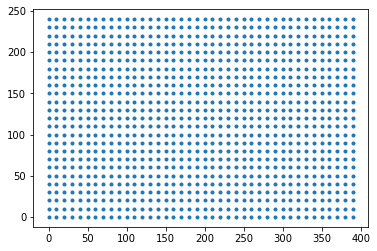

In [6]:
plt.plot(mg.x_of_node, mg.y_of_node, '.')

If we bothered to count, we'd see that there are indeed 1,000 grid nodes, and a corresponding number of `z` values:

In [7]:
len(z)

1000

Now for some tectonics. Let's say there's a fault trace that angles roughly east-northeast. We can describe the trace with the equation for a line. One trick here: by using `mg.x_of_node`, in the line of code below, we are calculating a *y* (i.e., north-south) position of the fault trace for each grid node---meaning that this is the *y* coordinate of the trace at the *x* coordinate of a given node.

In [8]:
fault_trace_y = 50.0 + 0.25 * mg.x_of_node

Here comes the earthquake. For all the nodes north of the fault (i.e., those with a *y* coordinate greater than the corresponding *y* coordinate of the fault trace), we'll add elevation equal to 10 meters plus a centimeter for every meter east along the grid (just to make it interesting):

In [9]:
z[mg.y_of_node > fault_trace_y] += 10.0 + 0.01 * mg.x_of_node[mg.y_of_node > fault_trace_y]

(A little bit of Python under the hood: the statement `mg.y_of_node > fault_trace_y` creates a 1000-element long boolean array; placing this within the index brackets will select only those array entries that correspond to `True` in the boolean array)

Let's look at our newly created initial topography using Landlab's *imshow_node_grid* plotting function (which we first need to import).

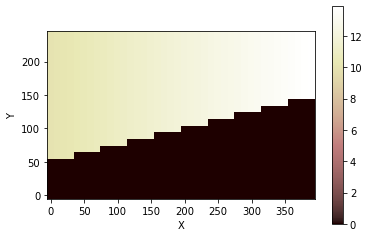

In [10]:
from landlab.plot.imshow import imshow_grid
imshow_grid(mg, 'topographic__elevation')

To finish getting set up, we will define two parameters: the transport ("diffusivity") coefficient, `D`, and the time-step size, `dt`. (The latter is set using the Courant condition for a forward-time, centered-space finite-difference solution; you can find the explanation in most textbooks on numerical methods).

In [11]:
D = 0.01  # m2/yr transport coefficient
dt = 0.2 * mg.dx * mg.dx / D
dt

2000.0

Boundary conditions: for this example, we'll assume that the east and west sides are closed to flow of sediment, but that the north and south sides are open. (The order of the function arguments is east, north, west, south)

In [12]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

*A note on boundaries:* with a Landlab raster grid, all the perimeter nodes are boundary nodes. In this example, there are 24 + 24 + 39 + 39 = 126 boundary nodes. The previous line of code set those on the east and west edges to be **closed boundaries**, while those on the north and south are **open boundaries** (the default). All the remaining nodes are known as **core** nodes. In this example, there are 1000 - 126 = 874 core nodes:

In [13]:
len(mg.core_nodes)

874

One more thing before we run the time loop: we'll create an array to contain soil flux. In the function call below, the first argument tells Landlab that we want one value for each grid link, while the second argument provides a name for this data *field*:

In [14]:
qs = mg.add_zeros('link', 'sediment_flux')

And now for some landform evolution. We will loop through 25 iterations, representing 50,000 years. On each pass through the loop, we do the following:

1. Calculate, and store in the array `g`, the gradient between each neighboring pair of nodes. These calculations are done on **links**. The gradient value is a positive number when the gradient is "uphill" in the direction of the link, and negative when the gradient is "downhill" in the direction of the link. On a raster grid, link directions are always in the direction of increasing $x$ ("horizontal" links) or increasing $y$ ("vertical" links).

2. Calculate, and store in the array `qs`, the sediment flux between each adjacent pair of nodes by multiplying their gradient by the transport coefficient. We will only do this for the **active links** (those not connected to a closed boundary, and not connecting two boundary nodes of any type); others will remain as zero.

3. Calculate the resulting net flux at each node (positive=net outflux, negative=net influx). The negative of this array is the rate of change of elevation at each (core) node, so store it in a node array called `dzdt'.

4. Update the elevations for the new time step.

In [15]:
for i in range(25):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt

Let's look at how our fault scarp has evolved.

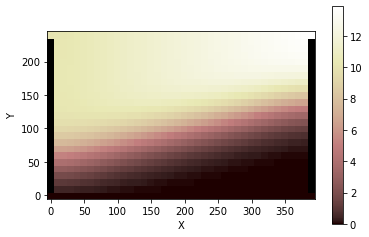

In [16]:
imshow_grid(mg, 'topographic__elevation')

Notice that we have just created and run a 2D model of fault-scarp creation and diffusion with fewer than two dozen lines of code. How long would this have taken to write in C or Fortran?

Complete code can be found here: https://github.com/landlab/tutorials/blob/release/fault_scarp/landlab-fault-scarp.py

## What's going on under the hood?

This example uses a finite-volume numerical solution to the 2D diffusion equation. The 2D diffusion equation in this case is derived as follows. Continuity of mass states that:

$\frac{\partial z}{\partial t} = -\nabla \cdot \mathbf{q}_s$,

where $z$ is elevation, $t$ is time, the vector $\mathbf{q}_s$ is the volumetric soil transport rate per unit width, and $\nabla$ is the divergence operator (here in two dimensions). (Note that we have omitted a porosity factor here; its effect will be subsumed in the transport coefficient). The sediment flux vector depends on the slope gradient:

$\mathbf{q}_s = -D \nabla z$,

where $D$ is a transport-rate coefficient---sometimes called *hillslope diffusivity*---with dimensions of length squared per time. Combining the two, and assuming $D$ is uniform, we have a classical 2D diffusion equation:

$\frac{\partial z}{\partial t} = -\nabla^2 z$.

For the numerical solution, we discretize $z$ at a series of *nodes* on a grid. The example in this notebook uses a Landlab *RasterModelGrid*, in which every interior node sits inside a cell of width $\Delta x$, but we could alternatively have used any grid type that provides nodes, links, and cells.

The gradient and sediment flux vectors will be calculated at the *links* that connect each pair of adjacent nodes. These links correspond to the mid-points of the cell faces, and the values that we assign to links represent the gradients and fluxes, respectively, along the faces of the cells.

The flux divergence, $\nabla \mathbf{q}_s$, will be calculated by summing, for every cell, the total volume inflows and outflows at each cell face, and dividing the resulting sum by the cell area. Note that for a regular, rectilinear grid, as we use in this example, this finite-volume method is equivalent to a finite-difference method.

To advance the solution in time, we will use a simple explicit, forward-difference method. This solution scheme for a given node $i$ can be written:

$\frac{z_i^{t+1} - z_i^t}{\Delta t} = -\frac{1}{A_i} \sum\limits_{j=1}^{N_i} \delta (l_{ij}) q_s (l_{ij}) \lambda(l_{ij})$.

Here the superscripts refer to time steps, $\Delta t$ is time-step size, $q_s(l_{ij})$ is the sediment flux per width associated with the link that crosses the $j$-th face of the cell at node $i$, $\lambda(l_{ij})$ is the width of the cell face associated with that link ($=\Delta x$ for a regular uniform grid), and $N_i$ is the number of active links that connect to node $i$. The variable $\delta(l_{ij})$ contains either +1 or -1: it is +1 if link $l_{ij}$ is oriented away from the node (in which case positive flux would represent material leaving its cell), or -1 if instead the link "points" into the cell (in which case positive flux means material is entering).

To get the fluxes, we first calculate the *gradient*, $G$, at each link, $k$:

$G(k) = \frac{z(H_k) - z(T_k)}{L_k}$.

Here $H_k$ refers the *head node* associated with link $k$, $T_k$ is the *tail node* associated with link $k$. Each link has a direction: from the tail node to the head node. The length of link $k$ is $L_k$ (equal to $\Delta x$ is a regular uniform grid). What the above equation says is that the gradient in $z$ associated with each link is simply the difference in $z$ value between its two endpoint nodes, divided by the distance between them. The gradient is positive when the value at the head node (the "tip" of the link) is greater than the value at the tail node, and vice versa.

The calculation of gradients in $z$ at the links is accomplished with the `calc_grad_at_link` function. The sediment fluxes are then calculated by multiplying the link gradients by $-D$. Once the fluxes at links have been established, the `calc_flux_div_at_node` function performs the summation of fluxes.

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>